# Implementation of Gaussian Naive Bayes

Naive Bayes is supervised learning algorithm that uses the probabilities of class attributes to make a prediction.

The name *Naive* comes from a strong assumption that the probability of each attribute belonging to a given class is independent of all other attributes.

The probability of a class given a value of an attribute is called the *conditional probability*. The product of the *conditional probabilities* of each attribute for a give class yields a probability of a data instance belonging to that class.

In [1]:
import itertools
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

## Data

The data used is the [Pima Indians Diabetes](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) problem:

* 768 Pima Indian female patients aged 21 or older.
* Each data instance contains numeric-only information such as age, number of times pregnant, blood pressure etc.
* A binary classification problem:
    * 1 if the patient suffered an onset of diabetes within 5 years of when the measurements were taken.
    * 0 otherwise.
    
The description of each attribute can found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names).

In [2]:
data = pd.read_csv(
    'pima_indians_diabetes.csv',
    header=None,
    names=[
        'Number of times pregnant',
        'Plasma glucose concentration',
        'Diastolic blood pressure',
        'Triceps skin fold thickness',
        '2-Hour serum insulin',
        'Body mass index',
        'Diabetes pedigree function',
        'Age',
        'Class' # 1 - diabetes, 0 - otherwise
    ]
)

data.describe().transpose()[['count', 'mean', 'std']]

,count,mean,std
Number of times pregnant,768.0,3.845052,3.369578
Plasma glucose concentration,768.0,120.894531,31.972618
Diastolic blood pressure,768.0,69.105469,19.355807
Triceps skin fold thickness,768.0,20.536458,15.952218
2-Hour serum insulin,768.0,79.799479,115.244002
Body mass index,768.0,31.992578,7.884160
Diabetes pedigree function,768.0,0.471876,0.331329
Age,768.0,33.240885,11.760232
Class,768.0,0.348958,0.476951


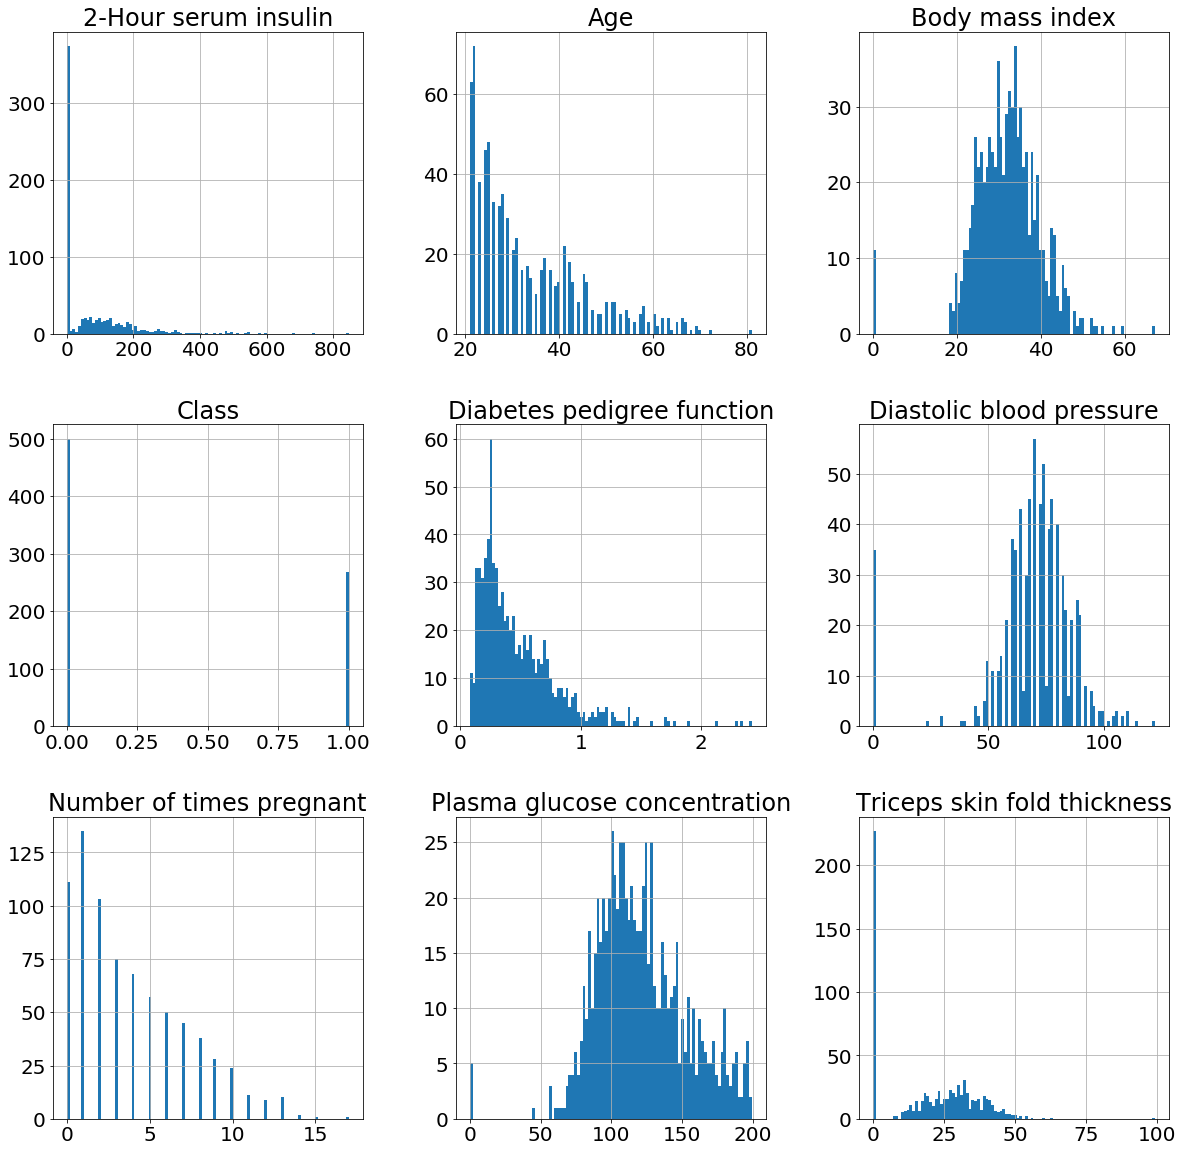

In [3]:
plt.rcParams['font.size'] = 20

data.hist(
    bins=100,
    figsize=(20, 20),
);

In [4]:
print('1 labels: %d' % data['Class'].sum())
print('0 labels: %d' % (len(data) - data['Class'].sum()))

1 labels: 268
0 labels: 500


In [5]:
mask = np.random.rand(len(data)) <= 0.7

training, test = data[mask], data[~mask]

print('Training data size: %d' % len(training))
print('Test data size: %d' % len(test))

Training data size: 547
Test data size: 221


## Making Predictions

Gaussian function can be used to calculate the probability of a class given a particular attribute value, knowing its mean and standard deviation.

$$ f(x) = \frac{ 1 }{ \sigma \sqrt{ 2 \pi } } e^{ \frac{ -(x-\mu)^2 }{ 2 \sigma^2 } }$$

In [6]:
mean_by_class = data.groupby('Class').mean()
std_by_class = data.groupby('Class').std()

In [7]:
def gaussian_fun(x, mu, sigma):
    return (
        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(
            -np.power(x - mu, 2) / (2 * np.power(sigma, 2))
        )
    ) 

## Implementation

In [8]:
class NaiveBayes():
    '''
        Classification algorithm.
    '''
    
    def fit(self, X, y):
        '''
            Fits numerical data only.
            y needs to be a column vector.
        '''
        
        assert len(X) == len(y), \
        'The length of X does not match the length of y.'
        
        X = np.array(X).reshape(len(X), -1)
        
        try:
            labels = set(y)
        except BaseException:
            raise ValueError('y needs to be a column vector.')
        
        for label in labels:
            assert type(label) in [int, float], \
            'y needs to have numerical values.'
        
        self.class_statistics = {} # holds mu and sigma of each attribute grouped by a class
        
        for label in labels:
            if label in self.class_statistics:
                continue
                
            self.class_statistics[label] = dict(
                mu = X[y == label, :].mean(axis=0),
                sigma = X[y == label, :].mean(axis=0)
            )
        
        return self
        
    def predict(self, X):

        X = np.array(X).reshape(len(X), -1)
        predictions = np.zeros((X.shape[0], len(self.class_statistics)))
        
        for i in range(X.shape[0]):
            for label, statistics in self.class_statistics.items():
                probabilities = gaussian_fun(
                    X[i, :], 
                    statistics['mu'],
                    statistics['sigma']
                )
                predictions[i, label] = np.log(probabilities).sum()
                
        return np.argmax(predictions, axis=1)

In [9]:
naive_bayes = NaiveBayes().fit(training.loc[:, :'Age'], training['Class'])
predictions = naive_bayes.predict(test.loc[:, :'Age'])

## Test results

Accuracy: 67.42%
             precision    recall  f1-score   support

          0       0.69      0.87      0.77       139
          1       0.61      0.34      0.44        82

avg / total       0.66      0.67      0.65       221



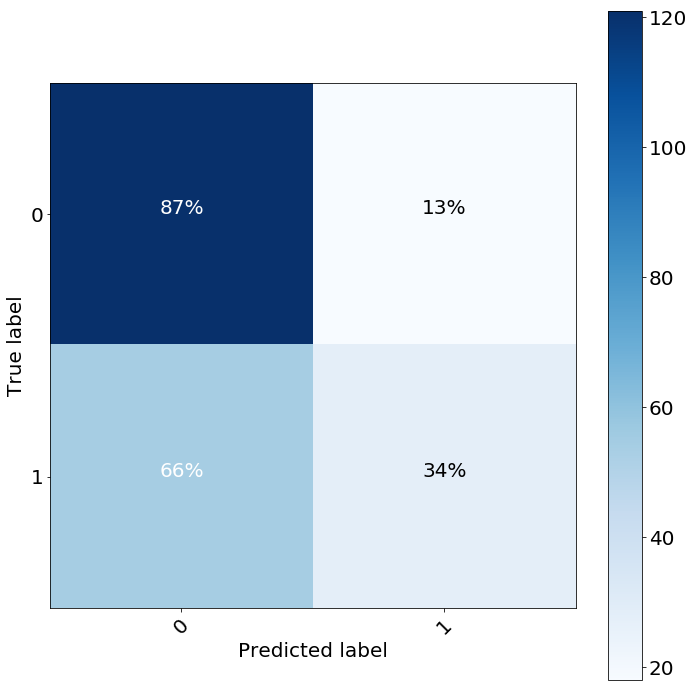

In [10]:
accuracy = 100 * sum(predictions == test['Class']) / len(test)

print("Accuracy: %.2f%%" % accuracy)
print(metrics.classification_report(test['Class'], predictions))
    
confusion_matrix = metrics.confusion_matrix(test['Class'], predictions)
classes = np.unique(test['Class'])

fig = plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

confusion_matrix = np.round(
    (confusion_matrix.astype('float') / 
     confusion_matrix.sum(axis=1)[:, np.newaxis]), 
    2
)

thresh = confusion_matrix.max() / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), 
                              range(confusion_matrix.shape[1])):

    plt.text(
        j, 
        i, 
        '%d%%' % (100 * confusion_matrix[i, j]),
        horizontalalignment="center",
        color="white" if confusion_matrix[i, j] > thresh else "black"
    )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Comparison with Sklearn

In [11]:
from sklearn.naive_bayes import GaussianNB

skl_naive_bayes = GaussianNB().fit(training.loc[:, :'Age'], training['Class'])
predictions = skl_naive_bayes.predict(test.loc[:, :'Age'])

Accuracy: 72.85%
             precision    recall  f1-score   support

          0       0.76      0.83      0.79       139
          1       0.66      0.56      0.61        82

avg / total       0.72      0.73      0.72       221



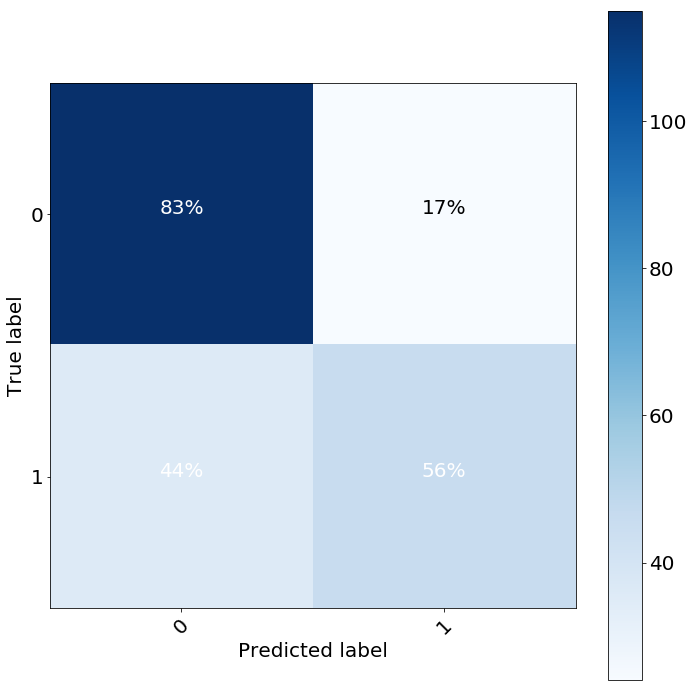

In [12]:
accuracy = 100 * sum(predictions == test['Class']) / len(test)

print("Accuracy: %.2f%%" % accuracy)
print(metrics.classification_report(test['Class'], predictions))
    
confusion_matrix = metrics.confusion_matrix(test['Class'], predictions)
classes = np.unique(test['Class'])

fig = plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

confusion_matrix = np.round(
    (confusion_matrix.astype('float') / 
     confusion_matrix.sum(axis=1)[:, np.newaxis]), 
    2
)

thresh = confusion_matrix.max() / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), 
                              range(confusion_matrix.shape[1])):

    plt.text(
        j, 
        i, 
        '%d%%' % (100 * confusion_matrix[i, j]),
        horizontalalignment="center",
        color="white" if confusion_matrix[i, j] > thresh else "black"
    )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()